# Reguralization in CNN networks
- we are going to compare various approaches to regularizarion in neural networks,
- we will use standard image classification task with CNN networks.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64
# learning rate is how fast it will descend
model_args['lr'] = .07
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 20
# L2 (ridge) penalty
model_args['L2_lambda'] = 5.e-3
# L1 (LASSO) penalty
model_args['L1_lambda'] = 2.e-4

### Define problem
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images to train image classifier,
- in order to test various regularizations our vanilla CNN classifier should be overfitted.

### Download the dataset

In [ ]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

'rm' is not recognized as an internal or external command,
operable program or batch file.


Files already downloaded and verified
Files already downloaded and verified


### Define CNN models and util methods
- (over)simpified CNN
- VGG11 (definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*)


In [ ]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}


def train_with_regularization(model, device, train_loader, optimizer, criterion,
                              epoch_number,
                              L1_lambda,
                              L2_lambda):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # L2 regularization implemeted by hand
        L2_norm = sum((p**2).sum() for p in model.parameters())
        # L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.parameters())
        #
        loss_regularized = loss + L1_norm*L1_lambda + L2_norm*L2_lambda
        # backpropagate the loss
        loss_regularized.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target)
            # get the index of class with the max probability
            prediction = output.argmax(dim=1)
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss.cpu(), accuracy

def run_training(model, device, criterion, optimizer, no_epochs,
                 L1_lambda=0.,
                 L2_lambda=0.):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train_with_regularization(model, device, train_loader,
                                optimizer, criterion, epoch_number,
                                L1_lambda, L2_lambda))
        val_loss, val_acc = test(model, device, validation_loader,
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments
- without any regularization
- *weigt_decay*, L2 regularization implemeted in optimizer, e.g. Adam or SGD as here: see [discussion](https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/6)
- L2 and L1 regularization implemeted by hand

Train Epoch: 1
	Train set: Average loss: 2.1212
	Validation set: Average loss: 2.0829, Accuracy: 1280/5000 (26%)
Train Epoch: 2
	Train set: Average loss: 1.7346
	Validation set: Average loss: 1.7127, Accuracy: 1864/5000 (37%)
Train Epoch: 3
	Train set: Average loss: 1.5556
	Validation set: Average loss: 1.5072, Accuracy: 2210/5000 (44%)
Train Epoch: 4
	Train set: Average loss: 1.4395
	Validation set: Average loss: 1.4425, Accuracy: 2355/5000 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3612
	Validation set: Average loss: 1.3748, Accuracy: 2461/5000 (49%)
Train Epoch: 6
	Train set: Average loss: 1.2860
	Validation set: Average loss: 1.3429, Accuracy: 2598/5000 (52%)
Train Epoch: 7
	Train set: Average loss: 1.2210
	Validation set: Average loss: 1.4287, Accuracy: 2437/5000 (49%)
Train Epoch: 8
	Train set: Average loss: 1.1601
	Validation set: Average loss: 1.3632, Accuracy: 2683/5000 (54%)
Train Epoch: 9
	Train set: Average loss: 1.1059
	Validation set: Average loss: 1.5293, Accuracy:

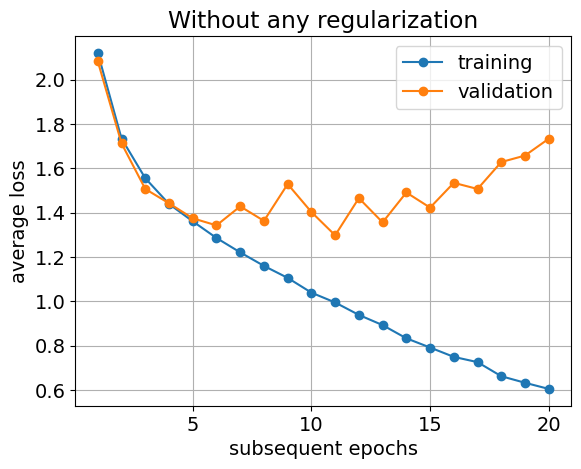

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_0, val_loss_0, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_0, val_loss_0, 'Without any regularization')
model_0_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.1267
	Validation set: Average loss: 1.8603, Accuracy: 1372/5000 (27%)
Train Epoch: 2
	Train set: Average loss: 1.7575
	Validation set: Average loss: 1.7439, Accuracy: 1737/5000 (35%)
Train Epoch: 3
	Train set: Average loss: 1.5857
	Validation set: Average loss: 1.5124, Accuracy: 2272/5000 (45%)
Train Epoch: 4
	Train set: Average loss: 1.4821
	Validation set: Average loss: 1.4942, Accuracy: 2306/5000 (46%)
Train Epoch: 5
	Train set: Average loss: 1.4129
	Validation set: Average loss: 1.4544, Accuracy: 2409/5000 (48%)
Train Epoch: 6
	Train set: Average loss: 1.3602
	Validation set: Average loss: 1.6175, Accuracy: 2070/5000 (41%)
Train Epoch: 7
	Train set: Average loss: 1.3033
	Validation set: Average loss: 1.3465, Accuracy: 2613/5000 (52%)
Train Epoch: 8
	Train set: Average loss: 1.2508
	Validation set: Average loss: 1.3550, Accuracy: 2569/5000 (51%)
Train Epoch: 9
	Train set: Average loss: 1.2166
	Validation set: Average loss: 1.3427, Accuracy:

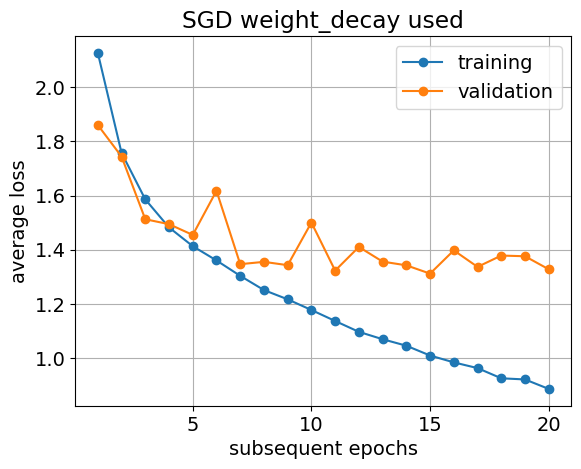

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=model_args['L2_lambda'])

train_loss_wd, val_loss_wd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_wd, val_loss_wd, 'SGD weight_decay used')
model_wd_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0195
	Validation set: Average loss: 1.8962, Accuracy: 1434/5000 (29%)
Train Epoch: 2
	Train set: Average loss: 1.6612
	Validation set: Average loss: 1.7609, Accuracy: 1910/5000 (38%)
Train Epoch: 3
	Train set: Average loss: 1.5456
	Validation set: Average loss: 1.5238, Accuracy: 2234/5000 (45%)
Train Epoch: 4
	Train set: Average loss: 1.4511
	Validation set: Average loss: 1.4897, Accuracy: 2289/5000 (46%)
Train Epoch: 5
	Train set: Average loss: 1.3890
	Validation set: Average loss: 1.4495, Accuracy: 2405/5000 (48%)
Train Epoch: 6
	Train set: Average loss: 1.3324
	Validation set: Average loss: 1.4104, Accuracy: 2529/5000 (51%)
Train Epoch: 7
	Train set: Average loss: 1.2891
	Validation set: Average loss: 1.4153, Accuracy: 2564/5000 (51%)
Train Epoch: 8
	Train set: Average loss: 1.2556
	Validation set: Average loss: 1.4774, Accuracy: 2400/5000 (48%)
Train Epoch: 9
	Train set: Average loss: 1.2205
	Validation set: Average loss: 1.3413, Accuracy:

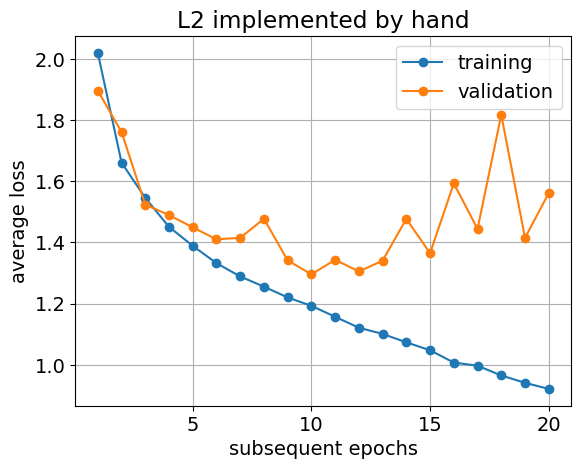

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l2, val_loss_l2, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0.,
                                                         L2_lambda=model_args['L2_lambda']/2.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l2, val_loss_l2, 'L2 implemented by hand')
model_l2_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0929
	Validation set: Average loss: 1.9427, Accuracy: 1397/5000 (28%)
Train Epoch: 2
	Train set: Average loss: 1.7339
	Validation set: Average loss: 1.5846, Accuracy: 2072/5000 (41%)
Train Epoch: 3
	Train set: Average loss: 1.5667
	Validation set: Average loss: 1.4654, Accuracy: 2335/5000 (47%)
Train Epoch: 4
	Train set: Average loss: 1.4537
	Validation set: Average loss: 1.7581, Accuracy: 2013/5000 (40%)
Train Epoch: 5
	Train set: Average loss: 1.3742
	Validation set: Average loss: 1.4832, Accuracy: 2317/5000 (46%)
Train Epoch: 6
	Train set: Average loss: 1.3186
	Validation set: Average loss: 1.4212, Accuracy: 2467/5000 (49%)
Train Epoch: 7
	Train set: Average loss: 1.2454
	Validation set: Average loss: 1.4487, Accuracy: 2342/5000 (47%)
Train Epoch: 8
	Train set: Average loss: 1.2042
	Validation set: Average loss: 1.4764, Accuracy: 2377/5000 (48%)
Train Epoch: 9
	Train set: Average loss: 1.1550
	Validation set: Average loss: 1.3807, Accuracy:

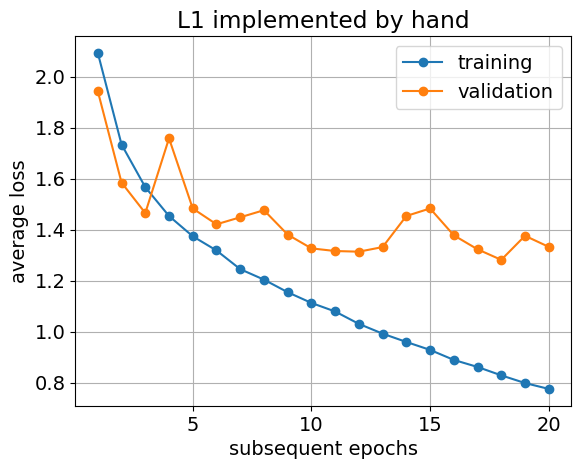

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=model_args['L1_lambda'],
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

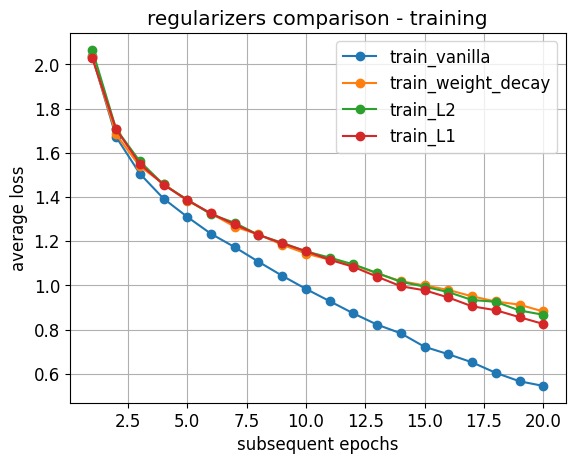

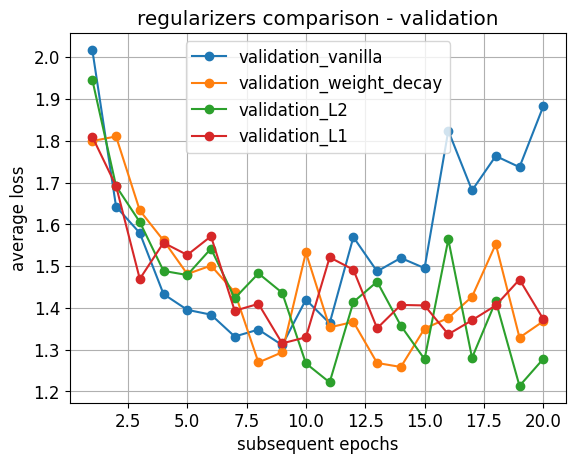

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), train_loss_0,  'o-', label='train_vanilla')
plt.plot(range(1, range_epochs), train_loss_wd, 'o-', label='train_weight_decay')
plt.plot(range(1, range_epochs), train_loss_l2, 'o-', label='train_L2')
plt.plot(range(1, range_epochs), train_loss_l1, 'o-', label='train_L1')
plt.legend()
plt.title("regularizers comparison - training")
plt.show()

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), val_loss_0,  'o-', label='validation_vanilla')
plt.plot(range(1, range_epochs), val_loss_wd, 'o-', label='validation_weight_decay')
plt.plot(range(1, range_epochs), val_loss_l2, 'o-', label='validation_L2')
plt.plot(range(1, range_epochs), val_loss_l1, 'o-', label='validation_L1')
plt.legend()
plt.title("regularizers comparison - validation")
plt.show()

Example weights:

In [ ]:
for p in model_0_params:
    print(p.shape)

np.set_printoptions(formatter={'float_kind': "{:.3f}".format})
# parameters for the second from last layer
print("vanilla:\n", model_0_params[-2][0])
print("L2 regularized:\n", model_l2_params[-2][0])
print("L1 regularized:\n", model_l1_params[-2][0])

(6, 3, 5, 5)
(6,)
(16, 6, 5, 5)
(16,)
(120, 400)
(120,)
(80, 120)
(80,)
(10, 80)
(10,)
vanilla:
 [0.216 0.048 0.194 0.062 0.081 -0.203 0.167 0.229 0.205 0.150 0.297 0.207
 -0.253 -0.141 0.152 0.175 0.079 -0.225 -0.216 0.038 -0.127 0.112 0.334
 -0.280 0.052 -0.038 -0.159 0.262 0.071 -0.355 -0.156 -0.125 -0.138 -0.114
 -0.173 -0.132 -0.074 0.296 -0.149 0.228 -0.334 -0.125 0.186 0.086 -0.045
 0.006 0.162 -0.269 0.095 -0.085 -0.039 -0.135 0.081 -0.174 -0.054 0.160
 -0.087 -0.141 0.148 -0.089 0.094 0.110 -0.001 -0.137 0.270 -0.334 -0.172
 -0.108 0.075 0.186 -0.041 -0.191 0.162 0.207 0.194 0.007 0.205 0.110
 -0.169 -0.086]
L2 regularized:
 [0.046 -0.104 -0.063 -0.046 -0.101 -0.040 -0.141 0.107 0.007 0.012 -0.145
 -0.028 0.014 0.132 0.042 0.049 0.144 -0.103 -0.102 0.339 -0.060 0.172
 0.150 -0.022 -0.057 0.002 -0.183 -0.018 0.104 -0.062 -0.004 0.044 0.234
 -0.141 0.081 -0.069 -0.137 0.059 0.147 0.106 0.080 -0.131 -0.195 -0.073
 -0.087 -0.197 -0.032 -0.127 -0.256 0.007 0.016 0.146 -0.078 0.202 

### Tasks to do:

0. Try to play with L2 and L1 *lambdas* do get highest possible accuracy.
- e.g. what if we increase *L1_lambda* to be the same as *L2_lambda*
1. Repeat the calculations but for the VGG11 model.
2. Compare amplitudes (plot histograms?) of model weights for the L2 and L1 case -- is L1 a strong feature selector?

3. Reimplement pytorch [SGD method](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD) to get L1 regularization (|w| instead of w**2)

Hint: change line
```python
if weight_decay != 0:
    d_p = d_p.add(param, alpha=weight_decay)
```
to
```python
if weight_decay != 0:
    d_p = d_p.add(torch.sign(param), alpha=weight_decay)
```

In [ ]:
from itertools import product

In [ ]:

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64
# learning rate is how fast it will descend
model_args['lr'] = .07
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 20
# L2 (ridge) penalty
model_args['L2_lambda'] = 5.e-3
# L1 (LASSO) penalty
model_args['L1_lambda'] = 2.e-4

In [ ]:
l1_values = [0., 1e-4, 2e-4, 5e-4]
l2_values = [0., 1e-3, 5e-3, 1e-2]

In [ ]:
accuracies = np.zeros([4,4])
for i, (l1, l2) in enumerate(product(l1_values, l2_values)):
  print(f'{l1=}, {l2=}')
  model = SimpleCNN().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
    model.parameters(),
    lr=model_args['lr'],
    weight_decay=0.
  )

  train_loss_l1, val_loss_l1, best_accuracy = run_training(
    model, device, criterion,
    optimizer, model_args['epochs'],
    L1_lambda=l1,
    L2_lambda=l2
  );
  accuracies[i%4, i//4] = best_accuracy

l1=0.0, l2=0.0
Train Epoch: 1
	Train set: Average loss: 2.0482
	Validation set: Average loss: 1.8671, Accuracy: 1594/5000 (32%)
Train Epoch: 2
	Train set: Average loss: 1.7085
	Validation set: Average loss: 1.5954, Accuracy: 2092/5000 (42%)
Train Epoch: 3
	Train set: Average loss: 1.5371
	Validation set: Average loss: 1.5331, Accuracy: 2197/5000 (44%)
Train Epoch: 4
	Train set: Average loss: 1.4308
	Validation set: Average loss: 1.4875, Accuracy: 2376/5000 (48%)
Train Epoch: 5
	Train set: Average loss: 1.3473
	Validation set: Average loss: 1.4737, Accuracy: 2354/5000 (47%)
Train Epoch: 6
	Train set: Average loss: 1.2822
	Validation set: Average loss: 1.5375, Accuracy: 2413/5000 (48%)
Train Epoch: 7
	Train set: Average loss: 1.2123
	Validation set: Average loss: 1.4431, Accuracy: 2546/5000 (51%)
Train Epoch: 8
	Train set: Average loss: 1.1537
	Validation set: Average loss: 1.3335, Accuracy: 2675/5000 (54%)
Train Epoch: 9
	Train set: Average loss: 1.0939
	Validation set: Average loss: 1.

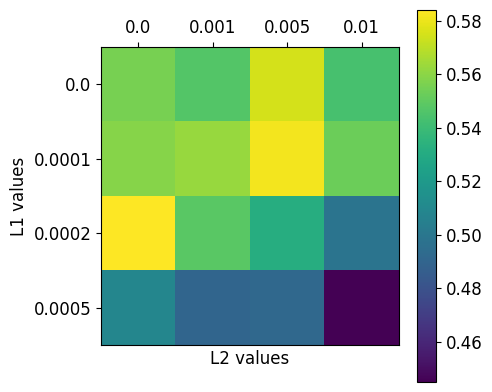

In [ ]:
plt.matshow(accuracies)
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks([0,1,2,3], labels=l1_values)
plt.ylabel('L1 values')
plt.xticks([0,1,2,3], labels=l2_values)
plt.xlabel('L2 values')
plt.colorbar()

plt.show()

In [ ]:
accuracies

array([[0.556, 0.547, 0.575, 0.543],
       [0.559, 0.562, 0.582, 0.553],
       [0.584, 0.549, 0.532, 0.499],
       [0.509, 0.491, 0.492, 0.445]])

In [ ]:
accuracies = np.zeros([4,4])
for i, (l1, l2) in enumerate(product(l1_values, l2_values)):
  print(f'{l1=}, {l2=}')
  model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
    model.parameters(),
    lr=model_args['lr'],
    weight_decay=0.
  )

  train_loss_l1, val_loss_l1, best_accuracy = run_training(
    model, device, criterion,
    optimizer, model_args['epochs'],
    L1_lambda=l1,
    L2_lambda=l2
  );
  accuracies[i%4, i//4] = best_accuracy

l1=0.0, l2=0.0
Train Epoch: 1
	Train set: Average loss: 2.1989
	Validation set: Average loss: 2.7542, Accuracy: 878/5000 (18%)
Train Epoch: 2
	Train set: Average loss: 1.9423
	Validation set: Average loss: 1.8843, Accuracy: 1404/5000 (28%)
Train Epoch: 3
	Train set: Average loss: 1.7227
	Validation set: Average loss: 1.6764, Accuracy: 1725/5000 (34%)
Train Epoch: 4
	Train set: Average loss: 1.5636
	Validation set: Average loss: 1.5318, Accuracy: 2145/5000 (43%)
Train Epoch: 5
	Train set: Average loss: 1.4074
	Validation set: Average loss: 1.3572, Accuracy: 2552/5000 (51%)
Train Epoch: 6
	Train set: Average loss: 1.2788
	Validation set: Average loss: 1.3909, Accuracy: 2496/5000 (50%)
Train Epoch: 7
	Train set: Average loss: 1.1637
	Validation set: Average loss: 1.6067, Accuracy: 2295/5000 (46%)
Train Epoch: 8
	Train set: Average loss: 1.0167
	Validation set: Average loss: 1.2323, Accuracy: 2866/5000 (57%)
Train Epoch: 9
	Train set: Average loss: 0.9132
	Validation set: Average loss: 1.1

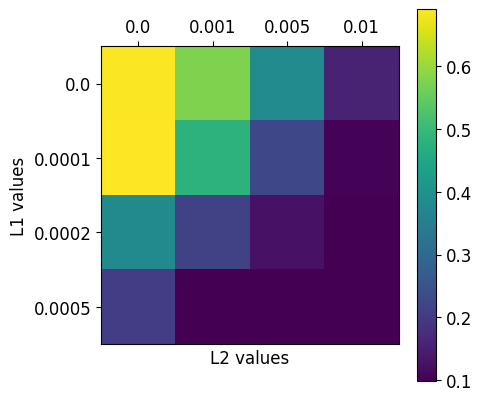

In [ ]:
plt.matshow(accuracies)
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks([0,1,2,3], labels=l1_values)
plt.ylabel('L1 values')
plt.xticks([0,1,2,3], labels=l2_values)
plt.xlabel('L2 values')
plt.colorbar()

plt.show()

In [ ]:
accuracies

array([[0.689, 0.577, 0.385, 0.155],
       [0.691, 0.481, 0.226, 0.104],
       [0.381, 0.214, 0.128, 0.098],
       [0.206, 0.098, 0.098, 0.098]])

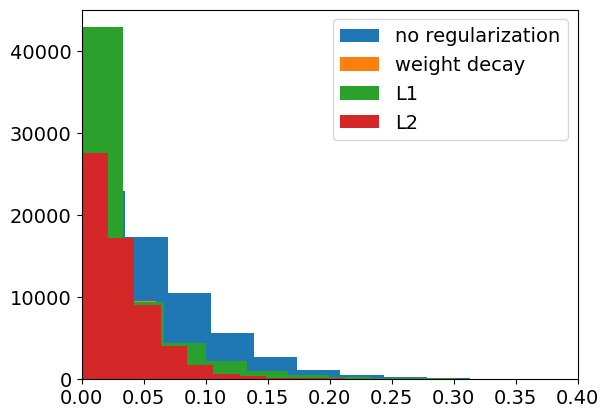

In [ ]:
parameters = model_0_params
no_reg = np.concatenate([abs(arr.flatten()) for arr in model_0_params])
wd = np.concatenate([abs(arr.flatten()) for arr in model_wd_params])
l1 = np.concatenate([abs(arr.flatten()) for arr in model_l1_params])
l2 = np.concatenate([abs(arr.flatten()) for arr in model_l2_params])
plt.hist(no_reg, label="no regularization", bins=30)
plt.hist(wd, label="weight decay", bins=30)
plt.hist(l1, label="L1", bins=30)
plt.hist(l2, label="L2", bins=30)
plt.xlim([0,.4])
plt.legend()

In [ ]:
no_reg.std(), wd.std(), l1.std(), l2.std()

(0.08476092, 0.047703795, 0.059978746, 0.04766136)

In [ ]:
from typing import List, Optional
from torch import Tensor

class L1_SGD(optim.SGD):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _single_tensor_sgd(params: List[Tensor],
                           d_p_list: List[Tensor],
                           momentum_buffer_list: List[Optional[Tensor]],
                           grad_scale: Optional[Tensor],
                           found_inf: Optional[Tensor],
                           *,
                           weight_decay: float,
                           momentum: float,
                           lr: float,
                           dampening: float,
                           nesterov: bool,
                           maximize: bool,
                           has_sparse_grad: bool):
        assert grad_scale is None and found_inf is None

        for i, param in enumerate(params):
            d_p = d_p_list[i] if not maximize else -d_p_list[i]

            if weight_decay != 0:
                d_p = d_p.add(torch.sign(param), alpha=weight_decay)

            if momentum != 0:
                buf = momentum_buffer_list[i]

                if buf is None:
                    buf = torch.clone(d_p).detach()
                    momentum_buffer_list[i] = buf
                else:
                    buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

                if nesterov:
                    d_p = d_p.add(buf, alpha=momentum)
                else:
                    d_p = buf

            param.add_(d_p, alpha=-lr)


Train Epoch: 1
	Train set: Average loss: 2.0760
	Validation set: Average loss: 1.8030, Accuracy: 1710/5000 (34%)
Train Epoch: 2
	Train set: Average loss: 1.7327
	Validation set: Average loss: 1.7860, Accuracy: 1838/5000 (37%)
Train Epoch: 3
	Train set: Average loss: 1.5605
	Validation set: Average loss: 1.5774, Accuracy: 2233/5000 (45%)
Train Epoch: 4
	Train set: Average loss: 1.4467
	Validation set: Average loss: 1.5460, Accuracy: 2276/5000 (46%)
Train Epoch: 5
	Train set: Average loss: 1.3627
	Validation set: Average loss: 1.5697, Accuracy: 2300/5000 (46%)
Train Epoch: 6
	Train set: Average loss: 1.3022
	Validation set: Average loss: 1.3845, Accuracy: 2537/5000 (51%)
Train Epoch: 7
	Train set: Average loss: 1.2384
	Validation set: Average loss: 1.3425, Accuracy: 2619/5000 (52%)
Train Epoch: 8
	Train set: Average loss: 1.1790
	Validation set: Average loss: 1.4564, Accuracy: 2535/5000 (51%)
Train Epoch: 9
	Train set: Average loss: 1.1258
	Validation set: Average loss: 1.3502, Accuracy:

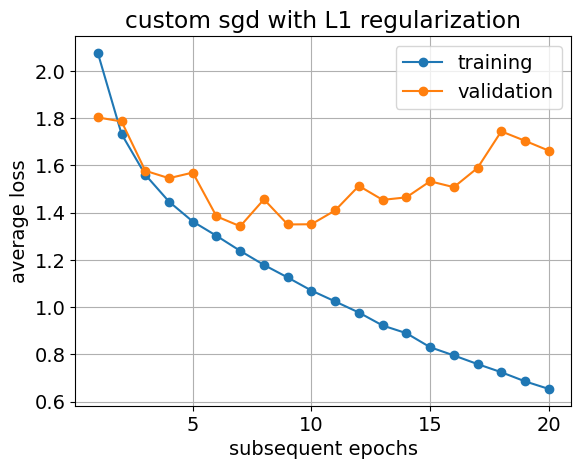

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = L1_SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=model_args['L1_lambda'])

train_loss_sgd, val_loss_sgd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_sgd, val_loss_sgd, 'custom sgd with L1 regularization')
model_sgd_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0662
	Validation set: Average loss: 1.8881, Accuracy: 1556/5000 (31%)
Train Epoch: 2
	Train set: Average loss: 1.7455
	Validation set: Average loss: 1.6063, Accuracy: 2046/5000 (41%)
Train Epoch: 3
	Train set: Average loss: 1.5617
	Validation set: Average loss: 1.6282, Accuracy: 2083/5000 (42%)
Train Epoch: 4
	Train set: Average loss: 1.4536
	Validation set: Average loss: 1.4536, Accuracy: 2360/5000 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3779
	Validation set: Average loss: 1.4074, Accuracy: 2501/5000 (50%)
Train Epoch: 6
	Train set: Average loss: 1.3181
	Validation set: Average loss: 1.4884, Accuracy: 2330/5000 (47%)
Train Epoch: 7
	Train set: Average loss: 1.2692
	Validation set: Average loss: 1.3481, Accuracy: 2574/5000 (51%)
Train Epoch: 8
	Train set: Average loss: 1.2228
	Validation set: Average loss: 1.4636, Accuracy: 2431/5000 (49%)
Train Epoch: 9
	Train set: Average loss: 1.1785
	Validation set: Average loss: 1.2827, Accuracy:

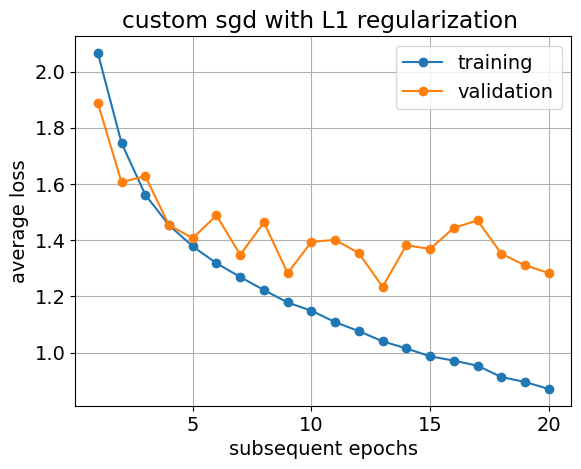

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = L1_SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=model_args['L2_lambda']) #larger value

train_loss_sgd, val_loss_sgd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_sgd, val_loss_sgd, 'custom sgd with L1 regularization ')
model_sgd_params = [p.detach().cpu().numpy() for p in model.parameters()]

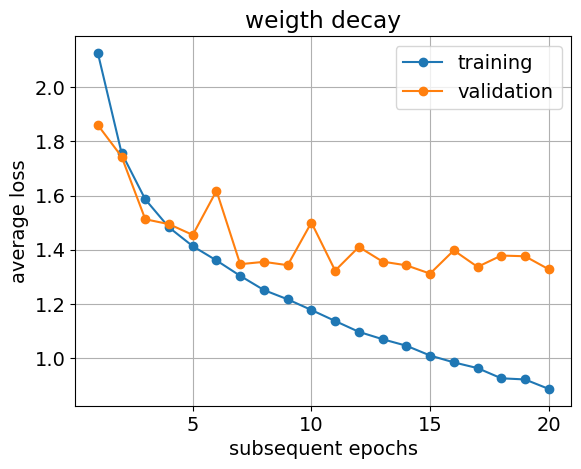

In [ ]:
plot_loss(train_loss_wd, val_loss_wd, 'weigth decay')

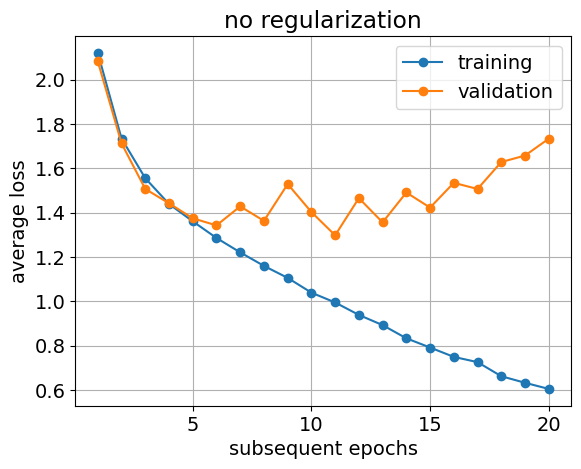

In [ ]:
plot_loss(train_loss_0, val_loss_0, 'no regularization')